In [1]:
import pandas as pd
import itertools
import random
import seaborn as sns
import skbio.stats.distance as ssd
from scipy.stats import kruskal
import matplotlib.pyplot as plt

The metadata field 'groups' is used to categorize the probands. 
- G1P is non-NAFLD controls; G1R first degree relatives
- G2P is NAFLD no advanced Fibrosis; G2R first degree relatives
- G3P is NAFLD-cirrhosis; G3R first degree relatives

In [2]:
#load unifrac distance matrix
uwdm = ssd.DistanceMatrix.read('../bdiv9k/unweighted_unifrac_dm.txt')
wdm = ssd.DistanceMatrix.read('../bdiv9k/unweighted_unifrac_dm.txt')
sample_arr = (wdm.ids)

In [3]:
mapfile = pd.read_table('../all_qiime_mapping_complete_corr_CC.txt', sep='\t', index_col=0)

In [4]:
len(sample_arr)

192

In [5]:
# make pairs of related and unrelated samples
allposs = list(itertools.combinations(sample_arr, 2)) # all possible pairs
rel = []
unrel = []
for pair in allposs:
    if (pair[0].split('.')[-2] == pair[1].split('.')[-2]): # if sample identifiers match
        rel.append(pair)
    else:
        unrel.append(pair)

In [6]:
len(unrel)

18232

In [7]:
# GROUP & house INFO
# for related pairs: split into G1s, G2s and G3s

pg1=[]
ph1=[]

pg2=[]
ph2=[]

pg3=[]
ph3=[]

for pair in rel:
    # if any assigned G1 (since they're twins, just one pair per family)
    if 'G1' in str(mapfile.loc[pair[0], 'groups']) or 'G1' in str(mapfile.loc[pair[1], 'groups']):
        pg1.append(pair)
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph1.append('shared')
        else:
            ph1.append('not shared')
        
    
    # if any assigned G2 (since they're twins, just one pair per family)   
    if 'G2' in str(mapfile.loc[pair[0], 'groups']) or 'G2' in str(mapfile.loc[pair[1], 'groups']):
        pg2.append(pair)
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph2.append('shared')
        else:
            ph2.append('not shared')
            
    # we want the proband in each pair? (don't have to do for twins as there's just one pair per proband)
    if 'G3P' in str(mapfile.loc[pair[0], 'groups']) or 'G3P' in str(mapfile.loc[pair[1], 'groups']):
        pg3.append(pair)
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph3.append('shared')
        else:
            ph3.append('not shared')

# make list of distances belonging to rel, G1, G2, G3, unrel
drel = [uwdm[pair] for pair in rel]
dg1 = [uwdm[pair] for pair in pg1]
dg2 = [uwdm[pair] for pair in pg2]
dg3 = [uwdm[pair] for pair in pg3]
dunrel = [uwdm[pair] for pair in unrel]

# create dataframe used to plot
pdf = pd.DataFrame(index=pd.MultiIndex.from_tuples(pg1+pg2+pg3+unrel), 
                   columns=['unweighted_unifrac','groups', 'housing', 'related'])

pdf.shape

(18318, 4)

**For housing, we used a positive filter here i.e 'shared' when both elements have housing=1 & 'not shared'
in all other cases. But some of the unknowns might be shared too. So we would like to remove such pairs below**

In [8]:
# assign groups
pdf.groups=['G1']*len(pg1)+['G2']*len(pg2)+['G3']*len(pg3)+['unrelated']*len(unrel)
# assign distances
pdf.unweighted_unifrac=dg1+dg2+dg3+dunrel
# assign relatedness
pdf.related = ['related']*len(pg1+pg2+pg3) + ['unrelated']*len(unrel)
#assign housing
pdf.housing = ph1+ph2+ph3 + ['unrelated']*len(unrel)

In [9]:
pdf.housing.unique()

array(['shared', 'not shared', 'unrelated'], dtype=object)

In [10]:
pdf.reset_index().to_csv('../tables/unweighted_UniFrac_per_pair.csv', sep=',', index=False)

In [11]:
# drop ambiguous housing pairs for which we don't have complete housing information
todrop=[]
for pair in pdf.index:
    if pdf.loc[pair, 'related']=='related':
        if mapfile.loc[pair[0], 'housing'] not in ['0', '1'] or mapfile.loc[pair[1], 'housing'] not in ['0', '1']:
            todrop.append(pair)
pdf2 = pdf.drop(todrop, axis=0)
pdf2.shape

(18289, 4)

### 1. microbiome distance distribution between related and unrelated individuals

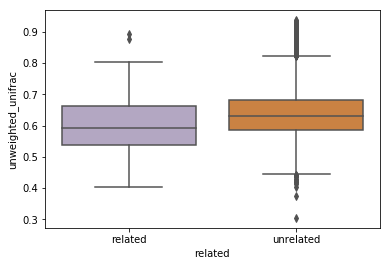

In [12]:
fig, ax = plt.subplots()
sns.boxplot(x='related', y='unweighted_unifrac', data=pdf, ax=ax,
            palette={'related':'#B3A2C7', 'unrelated':'#E1812C'})
plt.savefig('../figures/fig1c.1.unwtUF_related_unrelated.pdf', bbox_to_inches='tight')

In [13]:
# related vs. not related
g1 = list(pdf[pdf.related == 'related']['unweighted_unifrac'])
g2 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])
kruskal(g1, g2)

KruskalResult(statistic=17.28162430608063, pvalue=3.2228852279014334e-05)

### 2. microbiome distance between related and unrelated individuals stratified by shared housing

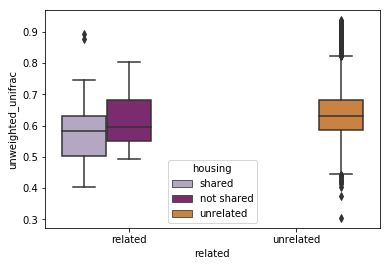

In [14]:
fig, ax = plt.subplots()
sns.boxplot(x='related', y='unweighted_unifrac', hue='housing', data=pdf, 
            palette={'shared':'#B3A2C7', 'not shared': '#871F78', 'unrelated': '#E1812C'})
# sns.swarmplot(x='related', y='unweighted_unifrac', hue='housing', data=pdf)
plt.savefig('../figures/fig1d.unwtUF_related_unrelated_housing.pdf', bbox_to_inches='tight')

In [15]:
# shared vs not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

g1 = list(pdfsub[pdfsub.housing == 'shared']['unweighted_unifrac'])
g2 = list(pdfsub[pdfsub.housing == 'not shared']['unweighted_unifrac'])
print(kruskal(g1, g2))

# not shared vs unrelated 
g3 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])
print(kruskal(g3, g2))
print(kruskal(g1,g3))

KruskalResult(statistic=3.9993238674779832, pvalue=0.045518520277724239)
KruskalResult(statistic=4.7678476500368561, pvalue=0.028996054509472777)
KruskalResult(statistic=15.120690576230118, pvalue=0.00010085186950756731)


### 3. microbiome distance between different disease groups

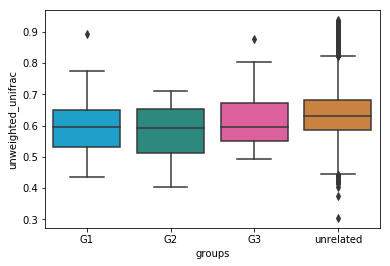

In [16]:
fig, ax = plt.subplots()
sns.boxplot(x='groups', y='unweighted_unifrac', data=pdf,
           palette={'G1':'#01AEE8', 'G2':'#1E988A', 'G3':'#F04D9C', 'unrelated':'#E1812C'})
plt.savefig('../figures/fig1c.2.unwtUF_groups_unrelated.pdf', bbox_to_inches='tight')

In [17]:
# kruskal wallis test for shared vs. not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

g1 = list(pdfsub[pdfsub.groups == 'G1']['unweighted_unifrac'])
g2 = list(pdfsub[pdfsub.groups == 'G2']['unweighted_unifrac'])
g3 = list(pdfsub[pdfsub.groups == 'G3']['unweighted_unifrac'])

g4 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])

print(kruskal(g1, g2))
print(kruskal(g2, g3))
print(kruskal(g1, g3))

print(kruskal(g1, g4))
print(kruskal(g2, g4))
print(kruskal(g3, g4))

KruskalResult(statistic=0.11267056530212471, pvalue=0.73712398150697123)
KruskalResult(statistic=1.6357452071737555, pvalue=0.20091024364769761)
KruskalResult(statistic=1.1994949494949481, pvalue=0.27342264497900259)
KruskalResult(statistic=10.523713867834886, pvalue=0.0011785240270705275)
KruskalResult(statistic=5.84076757333969, pvalue=0.015658994052663192)
KruskalResult(statistic=2.5937310908630025, pvalue=0.1072873340749159)


### 4. microbiome distance between different disease groups stratified by shared housing

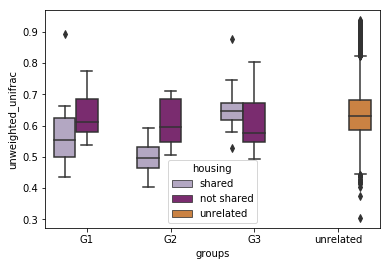

In [18]:
fig, ax = plt.subplots()
sns.boxplot(x='groups', y='unweighted_unifrac', hue='housing', data=pdf,
           palette={'shared':'#B3A2C7', 'not shared': '#871F78', 'unrelated': '#E1812C'})
plt.savefig('../figures/unwtUF_groups_unrelated_housing.pdf', bbox_to_inches='tight')